# Sensorx Contaminant Detection

### All package imports

In [1]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import os
import PIL #from PIL import Image
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from skimage.measure import regionprops, label

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.7.1
fastai        : 1.0.51
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 418.56
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 4035MB | Quadro M2000M

=== Environment === 
platform      : Linux-4.18.0-18-generic-x86_64-with-debian-buster-sid
distro        : #19~18.04.1-Ubuntu SMP Fri Apr 5 10:22:13 UTC 2019
conda env     : base
python        : /home/thor/miniconda3/bin/python
sys.path      : /home/thor/School/Scripts
/home/thor/miniconda3/lib/python37.zip
/home/thor/miniconda3/lib/python3.7
/home/thor/miniconda3/lib/python3.7/lib-dynload

/home/thor/miniconda3/lib/python3.7/site-packages
/home/thor/miniconda3/lib/python3.7/site-packages/IPython/extensions
/home/thor/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional

### Data

In [3]:
cwd = os.getcwd()

path = Path(cwd + '/TestData/')
path.ls()

[PosixPath('/home/thor/School/Scripts/TestData/images'),
 PosixPath('/home/thor/School/Scripts/TestData/codes.txt'),
 PosixPath('/home/thor/School/Scripts/TestData/files.txt'),
 PosixPath('/home/thor/School/Scripts/TestData/masks'),
 PosixPath('/home/thor/School/Scripts/TestData/valid.txt')]

In [4]:
path_lbl = path/'masks'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/thor/School/Scripts/TestData/images/MAGNA_30_78.1731CL_3.32054kg.tiff'),
 PosixPath('/home/thor/School/Scripts/TestData/images/MAGNA_99_93.71CL_2.84815kg.tiff'),
 PosixPath('/home/thor/School/Scripts/TestData/images/MAGNA_31_83.4158CL_3.18242kg.tiff')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/thor/School/Scripts/TestData/masks/MAGNA_30_78.1731CL_3.32054kg.tiff'),
 PosixPath('/home/thor/School/Scripts/TestData/masks/MAGNA_99_93.71CL_2.84815kg.tiff'),
 PosixPath('/home/thor/School/Scripts/TestData/masks/MAGNA_31_83.4158CL_3.18242kg.tiff')]

### Removing images with no contaminant

In [7]:
allFiles = [file.name for file in fnames]

inF = open("noContaminant.txt", "r")
files = inF.readlines()
inF.close()

files = [f[:-1] for f in files]

size = len(allFiles) - 1
for i, name in enumerate(allFiles[::-1]):
    if name in files:
        idxToDelete = size - i
#         print(f'{name} - {idxToDelete}\n--{fnames[idxToDelete]}\n--{lbl_names[idxToDelete]}')
        del fnames[idxToDelete]
        del lbl_names[idxToDelete]


### Selecting validation images

In [8]:
# # Select 10% validation images and handpicked meatl images
# metal = ['MAGNA_3_86.3626CL_3.97524kg.tiff',
# 'MAGNA_20_78.9422CL_0.960883kg.tiff', 
# 'MAGNA_48_-1CL_0.437527kg.tiff', 
# 'MAGNA_49_-1CL_0.440395kg.tiff', 
# 'MAGNA_50_-1CL_0.317512kg.tiff', 
# 'MAGNA_51_-1CL_0.453667kg.tiff', 
# 'MAGNA_52_-1CL_0.360127kg.tiff', 
# 'MAGNA_53_-1CL_0.446551kg.tiff', 
# 'MAGNA_54_-1CL_0.441927kg.tiff', 
# 'MAGNA_55_-1CL_0.454831kg.tiff', 
# 'MAGNA_56_-1CL_0.446517kg.tiff', 
# 'MAGNA_57_-1CL_0.442111kg.tiff', 
# 'MAGNA_58_-1CL_0.453068kg.tiff', 
# 'MAGNA_59_-1CL_0.328768kg.tiff', 
# 'MAGNA_60_-1CL_0.439103kg.tiff', 
# 'MAGNA_61_83.7706CL_3.88116kg.tiff']

# no_metal_names = np.array([img.name for img in fnames])
# for metal_img in metal:
#     no_metal_names = no_metal_names[no_metal_names != metal_img]

# validation_count = len(no_metal_names) // 10 # 10% of the non-metal images
# validation_files = np.random.choice(no_metal_names, size=validation_count, replace=False)
# validation_metal = ['MAGNA_56_-1CL_0.446517kg.tiff', 'MAGNA_61_83.7706CL_3.88116kg.tiff',
#                              'MAGNA_54_-1CL_0.441927kg.tiff']
# validation_files = np.append(validation_files, validation_metal)

# outF = open(str(path) + "/valid.txt", "w")
# output = map(lambda x: x + '\n', validation_files)
# outF.writelines(output)
# outF.close()

### Data

Image (3, 700, 768)


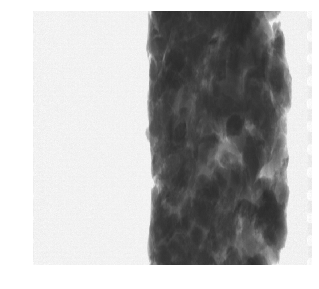

In [9]:
## Data

img_f = fnames[0]
img = open_image(img_f)
print(img)
img.show(figsize=(5,5))

Example label


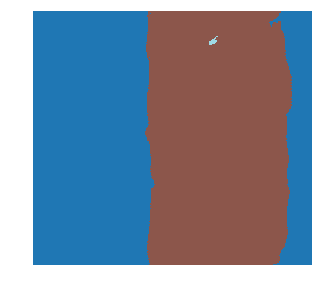

In [10]:
def get_y_fn(x):
    ''' Returns the corresponding labeled image 
    x - Image name in the dataset
    '''
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
print("Example label")
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])

### Selecting image channels to use

In [11]:
layers = {"highImg": 0, "lowImg": 1, "plastImg": 2, "alImg": 3, "lowImgReg": 4, "highImgReg": 5}

def read_tiff(img, images_to_use=["lowImgReg", "highImgReg"]):
    """ Reads the desired layers as a multi channel/layer tiff image
    img           - Full file path to the image
    images_to_use - The images/layers/channels to use
    """
    n_images = len(images_to_use)
    if n_images > 1:
        channels = 3           # The FastAI library as, "lowImg"sumes 1 or 3 channels in many cases
    else:
        channels = 1

    images = []
    for i in range(channels):
        if i < n_images:
            img.seek(i)
            slice_ = np.array(img)
            images.append(slice_)
        else:
            slice_ = np.ones(slice_.shape)
            images.append(slice_)

    return np.transpose(np.array(images), (1, 2, 0)) # The FastAI expects this strange dimension order, then it transposes back

img = PIL.Image.open(path / 'images/MAGNA_3_86.3626CL_3.97524kg.tiff')
image = read_tiff(img)

### Preparing the dataset

In [12]:
## Datasets
bs,size = 2,src_size//2
# transforms = ([RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True)],
#               [RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45.0, 45.0)}, p=1.0, resolved={}, do_run=True, is_random=True)])

# Two lists of transforms (train and valid)
# 
transforms = ([RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.9, resolved={}, do_run=True, is_random=True)],
              [RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.0, resolved={}, do_run=True, is_random=True)])

src = (SegmentationItemList.from_folder(path_img, convert_mode=None, extensions=('.tiff'), after_open=read_tiff)
       .split_by_fname_file(str(path) + '/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(transforms, size=size, tfm_y=True) # tfm_y=True to apply the same transform to the mask
        .databunch(bs=bs)
        .normalize(imagenet_stats))

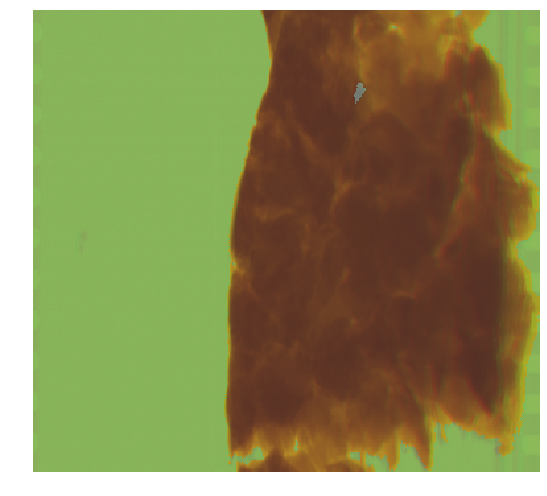

In [13]:
data.show_batch(1, figsize=(10,7))

### Custom metric functions

In [14]:
def numb_contaminants(data):
    '''
    data - Labeled image
    '''
    data = data.cpu().numpy().astype(int)
        
    data[data == 1] = 0  # Set meat as background

    labels = label(data, background=0) # same image_binary as above
    regions = regionprops(labels)
    contaminant_count = len(regions)
    return float(contaminant_count)

def numb_incorrect_contaminants(input, target):
    ''' Computes the average number of incorrect number of contaminants in labeled image
    input  - The predicted output
    target - The true labels
    '''
    input = input.argmax(dim=1)
    target = target.squeeze(1)
    
    count_incorrect = numb_contaminants(input) - numb_contaminants(target)
    
    ret = torch.Tensor(1)
    ret[0] = count_incorrect
    return ret

def numb_incorrect_contaminant_pixels(input, target):
    ''' Counts total number of incorrect pixels
    input  - The predicted output
    target - The true labels
    '''
    input = input.argmax(dim=1)
    target = target.squeeze(1)
    
    target = target.cpu().numpy().astype(int)
    input = input.cpu().numpy().astype(int)

    total_pixel_count = len(target[target == 2]) + len(target[target == 3])
    
    total_predicted_pixel_count = len(input[input == 2]) + len(input[input == 3])
    
    bones = input[(target == 2)] # TODO: Remove this... monitor all incorrect pixels
    metals = input[(target == 3)]
    predicted_correct_pixels = len(bones[(bones == 2)]) + len(metals[(metals == 3)])
    predicted_wrong_pixels = total_predicted_pixel_count - predicted_correct_pixels

    ret = torch.Tensor(1)
    ret[0] = float(total_pixel_count - predicted_correct_pixels + predicted_wrong_pixels)
    return ret

### Defining the loss function

In [15]:
weights = torch.FloatTensor([0., 1., 2., 4.]) # ['Belt', 'Meat', 'Bone', 'Metal'])
def forward(y_hat, y)->Rank0Tensor:  # This custom loss did not work with the backpropagation
    '''
    input  - The predicted output
    target - The true labels
    '''
    y_hat = y_hat.argmax(dim=1)
    y = y.squeeze(1)
    
    costs = weights[y] * torch.log(y_hat.float() + 1e-16)
    cost = costs.sum().double()
    return cost

weight = torch.FloatTensor([1., 1., 2., 4.]).cuda()
def customLossFunction(input, target):
    '''
    input  - The predicted output
    target - The true labels
    '''
    target = target.squeeze(1)
    return F.nll_loss(torch.log_softmax(input, 1), target, weight, reduction='mean')
    
class CustomWeightedCrossEntropyLoss():
    "Weighted Cross Entropy Loss."
    
    def __init__(self):
        self.weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
        self.func = nn.CrossEntropyLoss(self.weight)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"Custom weighted {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        '''
        input  - The predicted output
        target - The true labels
        '''
        target = target.squeeze(1)        
        return self.func.__call__(input, target, **kwargs)

In [16]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        '''
        input  - The predicted output
        target - The true labels
        '''
    
        print(input.requires_grad)  # True
        print(target.requires_grad) # False
        if not (target.size() == input.size()):
            input = input.argmax(dim=1)#.float()
            target = target.squeeze(1).float()
        
        print(input.requires_grad) # False
        print(target.requires_grad)# False

        max_val = (-input).clamp(min=0)
        print(max_val)
        print(type(max_val))
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        '''
        input  - The predicted output
        target - The true labels
        '''
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()
    
class FocalLossNoMeat(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        '''
        input  - The predicted output
        target - The true labels
        '''
        
        input = input.argmax(dim=1).float()
        target = target.squeeze(1).float()
        
        print(input)
        input[target == 1] = 0.    # Changs all meat to background
        print(input)
        print(target)
        return self.focal(input, target)

In [17]:
# from stuff.learner import *

# Edit from: https://forums.fast.ai/t/deeplearning-lec9-notes/14113
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data] # was .cpu()

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        '''
        pred - The predicted output
        targ - The true labels
        '''
#         print("pred", pred.requires_grad)
#         print("targ", targ.requires_grad)
        
#         print("targ", targ, targ.size())
        t = one_hot_embedding(targ, self.num_classes).cuda()
#         print("t", t, t.size(), type(t))
#         t = V(t[:,:-1].contiguous()) # V(t[:,:-1].contiguous()) #.cpu() , gpu()?
#         print("t", t, t.size(), type(t))
        t = t.permute(0,3,1,2)
#         print("t", t, t.size(), type(t))
#         print("pred", pred, pred.size())
        x = pred
#         x = pred[:,:-1] # Here we skip the background (That might be a good idea)
#         print("x", x, x.size())
        w = self.get_weight(x, t)
        
        alpha,gamma = 0.25, 2.
#         p = x.sigmoid()
        p = x
#         print("p", p, p.size(), type(p))
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        w = w * (1-pt).pow(gamma)
    
        print("w", w.requires_grad)
        print("x", x.requires_grad)
        print("t", t.requires_grad)
        # Reduce was => size_average=False
        return F.binary_cross_entropy_with_logits(x, t, w, reduction='sum')/self.num_classes
    
    def get_weight(self,x,t): return None
    
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25, 2.
        p = x.sigmoid()
        print("p", p, p.size(), type(p))
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [18]:
# Edit from https://github.com/samuelschen/DSB2018/blob/master/loss.py
class FocalLoss(nn.Module):
    """
    Focal Loss for Dense Object Detection [https://arxiv.org/abs/1708.02002]
    Digest the paper as below:
        α, balances the importance of positive/negative examples
        γ, focusing parameter that controls the strength of the modulating term
            CE(pt) = −log(pt) ==> pt = exp(-CE)
            FL(pt) = −α((1 − pt)^γ) * log(pt)
        In general α should be decreased slightly as γ is increased (for γ = 2, α = 0.25 works best).
    """
    def __init__(self, focusing_param=2., balance_param=0.25, num_classes=4):
        super().__init__()
        self.gamma = focusing_param
        self.alpha = balance_param
        self.num_classes = num_classes

    def forward(self, inputs, targets, weights=None):
        '''
        inputs  - The predicted output
        targets - The true labels
        weights - 
        '''
#         targets[targets == 1] = 0 # This changes the meat to background
        targ = one_hot_embedding(targets, self.num_classes).cuda()
#         print("targ", targ, targ.size(), type(targ), np.unique(targ))
        targ = targ.permute(0,3,1,2)
#         print("targ", targ, targ.size(), type(targ), np.unique(targ))
        uniq = np.unique(inputs)
#         print("inputs", inputs, inputs.size(), type(inputs), uniq, uniq.min(), uniq.max())
        pred = inputs.sigmoid() # This added since the inputs are in the range [-13.611954:7.559714]
        # But should be in the range [0:1] for the binary_cross_entropy
#         print("pred", pred, pred.size(), type(pred), np.unique(pred))
    
        # Might want # -F.cross_entropy(inputs, targ, weights, reduction='sum')
        logpt = -F.binary_cross_entropy(pred, targ, weights)
        # The logpt is probably the same as nn.BCEWithLogitsLoss() see: https://gombru.github.io/2018/05/23/cross_entropy_loss/ (Binary Cross-Entropy Loss)
        pt = torch.exp(logpt)
        # compute the loss
        focal_loss = -((1-pt)**self.gamma) * logpt
        balanced_focal_loss = self.alpha * focal_loss
        return balanced_focal_loss


In [19]:
def IoU(input:Tensor, targs:Tensor)->Rank0Tensor:
    '''
    input  - The predicted output
    target - The true labels
    '''
    return dice(input, targs, iou=True) # Use the IoU function implemented in FastAI

### Setting up the convolutional network

In [20]:
def pretrained_model(pretrained=True):
    return models.resnet34(pretrained)

wd=1e-2 # Weight decay

weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
learn = unet_learner(data, pretrained_model, wd=wd, loss_func=FocalLoss()))#, loss_func=nn.CrossEntropyLoss(weight))

# learn.crit = FocalLoss(2.0)
# learn.crit = FocalLossNoMeat(5.0)
# learn.crit = dice_loss
learn.metrics=[dice, IoU, numb_incorrect_contaminants, numb_incorrect_contaminant_pixels]

In [21]:
help(models.resnet34)

Help on function resnet34 in module torchvision.models.resnet:

resnet34(pretrained=False, **kwargs)
    Constructs a ResNet-34 model.
    
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet



In [22]:
x, y = data.one_batch(DatasetType.Train, True, True)
data.one_batch

<bound method DataBunch.one_batch of ImageDataBunch;

Train: LabelList (103 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: .;

Valid: LabelList (13 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: .;

Test: None>

In [23]:
learn.loss_func, data.loss_func

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [24]:
# learn.summary()

In [25]:
# lr_find(learn)

In [26]:
# learn.recorder.plot()

In [27]:
lr=1e-4

In [28]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,IoU,numb_incorrect_contaminants,numb_incorrect_contaminant_pixels,time
0,0.534428,0.244053,0.914686,0.847523,7.076923,1812.846191,01:01
1,0.197025,0.073889,0.987200,0.975199,0.307692,1480.769287,00:47
2,0.093301,0.055901,0.995739,0.991821,-2.923077,1471.230713,00:47


In [29]:
learn.save('stage-1-big')

In [30]:
learn.load('stage-1-big');

In [31]:
learn.unfreeze()

In [32]:
lrs = slice(1e-6,lr/10)

In [33]:
learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,dice,IoU,numb_incorrect_contaminants,numb_incorrect_contaminant_pixels,time
0,0.035104,0.058556,0.995611,0.991561,-3.692308,1467.538452,00:51
1,0.033560,0.047070,0.997850,0.996010,-3.846154,1466.000000,00:51
2,0.030480,0.054820,0.995739,0.991808,-4.000000,1465.076904,00:51


In [34]:
learn.save('stage-2-big')

In [35]:
learn.load('stage-2-big');

### Visual inspection of the validation data

In [36]:
preds,y = learn.get_preds()

In [37]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth / Predictions
########################
There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


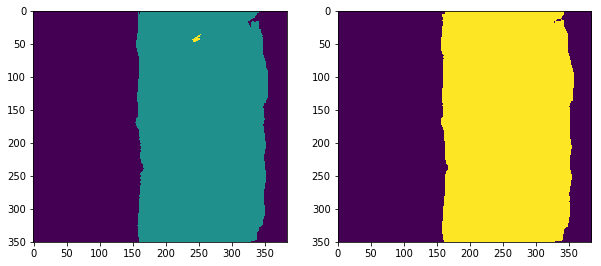

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 8548, Metal: 0, Groups total: 15.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


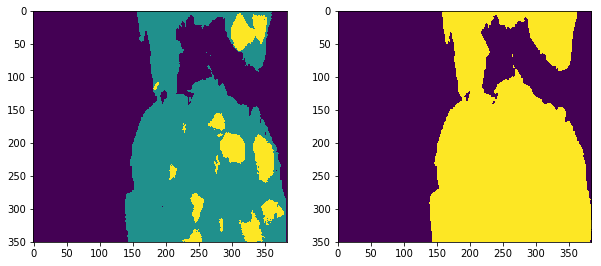

There is Metal / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 0, Metal: 1, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


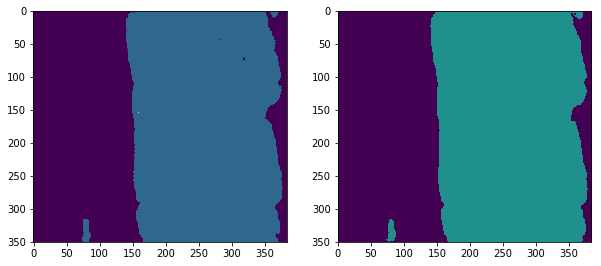

There is Metal / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 0, Metal: 3, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


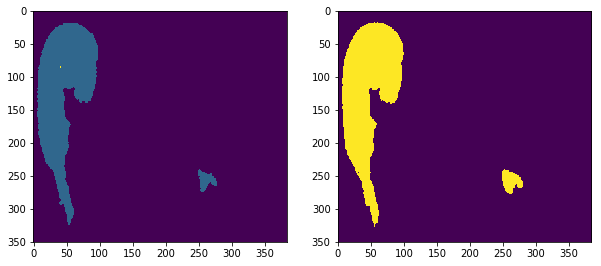

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


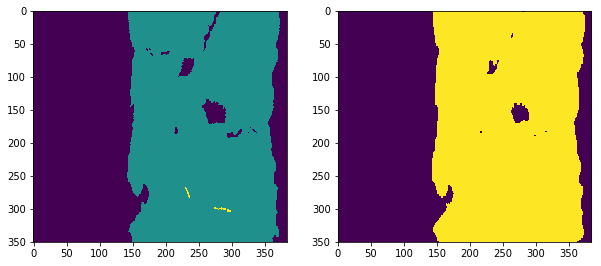

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 108, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


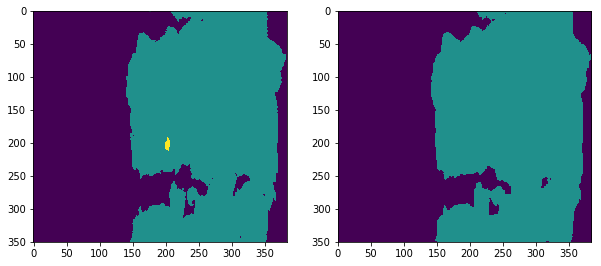

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 181, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


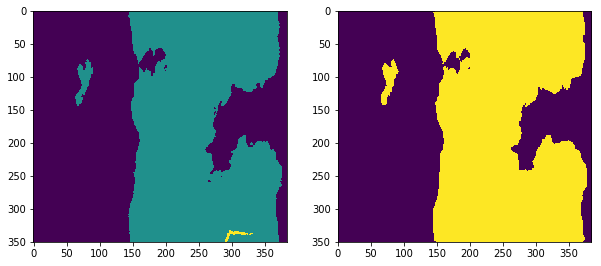

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 47, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


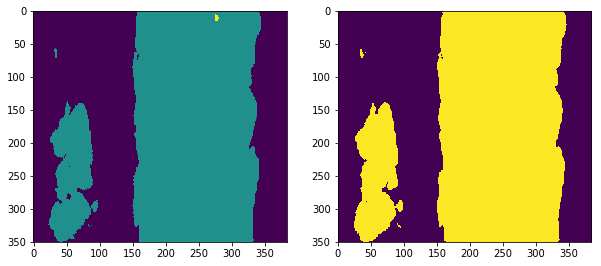

There is Metal / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 0, Metal: 2, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


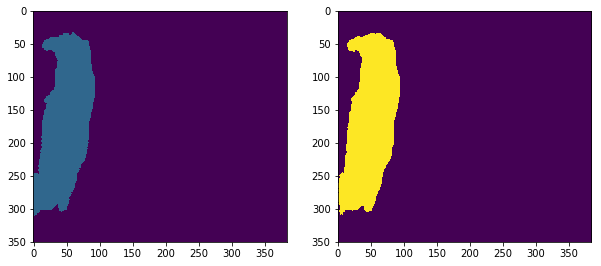

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 231, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


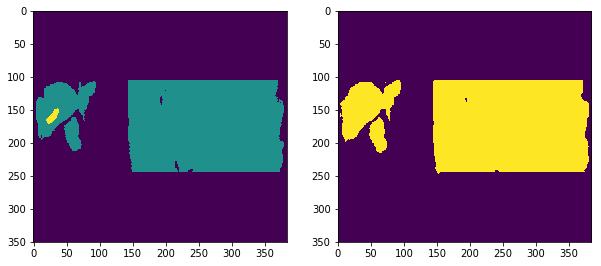

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 27, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


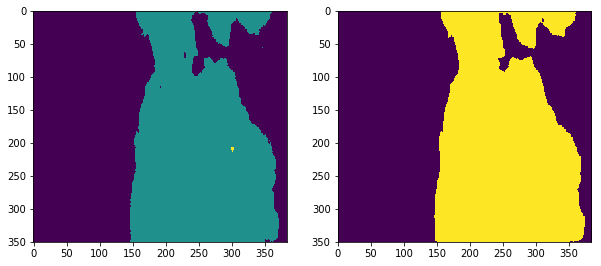

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


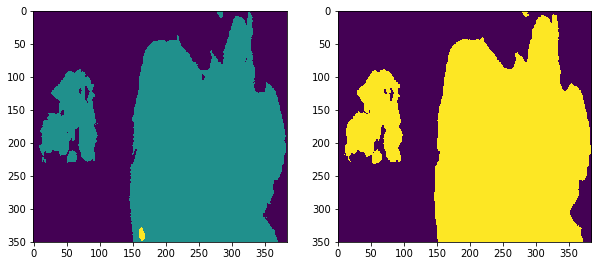

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 150, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


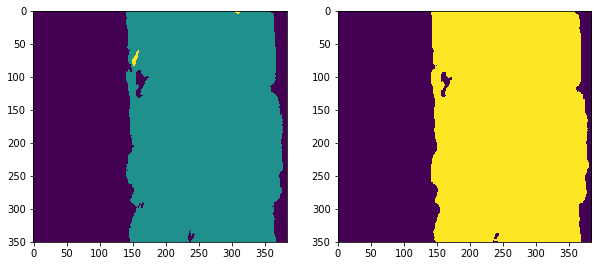

In [38]:
y = torch.squeeze(y)
print("########################")
print("Ground truth / Predictions")
print("########################")
for i in range(preds.shape[0]):
    prediction = preds.argmax(dim=1)[i]
    print("There is {} / Found {}".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print(np.unique(prediction))
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}, Groups total: {}".format(len(y[i][y[i] == 2]), len(y[i][y[i] == 3]), numb_contaminants(y[i])))
    print("Prediction   -> Bone: {}, Metal: {}, Groups total: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3]), numb_contaminants(prediction)))
    plt.show()
    

### The three metal images selcted for metal validation

Time for prediction: 0.1759943962097168 seconds
There is Metal / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 0, Metal: 11, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


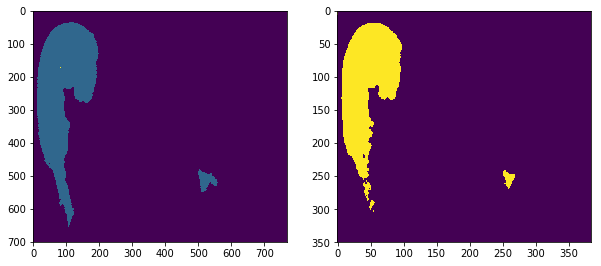

Time for prediction: 0.1733098030090332 seconds
There is Metal / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 0, Metal: 3, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


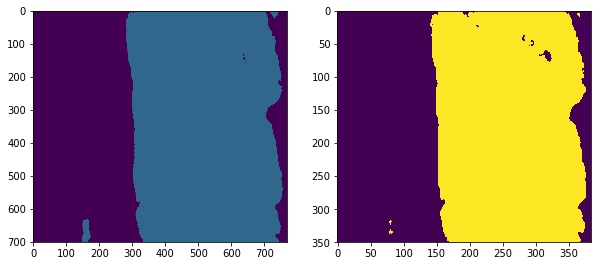

Time for prediction: 0.1747598648071289 seconds
There is Metal / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 0, Metal: 5, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


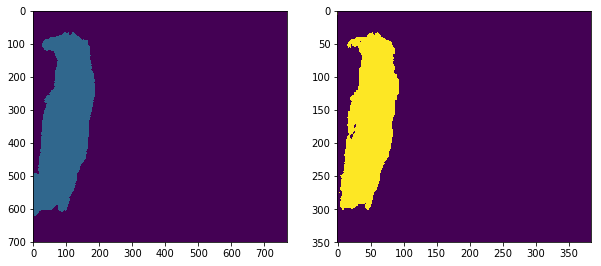

In [39]:
import time

# These validaion_metals are defined here above
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tiff', 'MAGNA_61_83.7706CL_3.88116kg.tiff',
                             'MAGNA_54_-1CL_0.441927kg.tiff']
for name in validation_metal:
    groundTruth = open_image(path / ('masks/' + name), div=False).data[0, :, :]
    t = time.time()
    preds = learn.predict(open_image(path / ('images/' + name)))
    elapsed = time.time() - t
    print("Time for prediction: {} seconds".format(elapsed))

    prediction = preds[1][0, :, :]
    print("There is {} / Found {}".format(getContanimentInfo(groundTruth), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(groundTruth)
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print(np.unique(prediction))
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}, Groups total: {}".format(len(groundTruth[groundTruth == 2]), len(groundTruth[groundTruth == 3]), numb_contaminants(groundTruth)))
    print("Prediction   -> Bone: {}, Metal: {}, Groups total: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3]), numb_contaminants(prediction)))
    plt.show()

In [40]:
# Check on the Trainable - True/False
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 175, 192]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 175, 192]       128        True      
______________________________________________________________________
ReLU                 [64, 175, 192]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 96]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 96]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 88, 96]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 96]         0          False     
______________________________________________________________